# Task 2: Time Series Forecasting Models

## SPY Stock Price Prediction

This task involves building a time series forecasting model to predict SPY's future stock prices. Below are the step-by-step instructions to develop, evaluate, and refine a forecasting model using common techniques such as **ARIMA**, **SARIMA**, or **LSTM**.

### Step-by-Step Instructions:

#### 1. Choose a Model:
- **ARIMA (AutoRegressive Integrated Moving Average):**  
  Suitable for univariate time series with no seasonality.
- **SARIMA (Seasonal ARIMA):**  
  Extends ARIMA by considering seasonality.
- **LSTM (Long Short-Term Memory):**  
  A type of recurrent neural network (RNN) well-suited for capturing long-term dependencies in time series data.

#### 2. Split the Dataset:
- Divide the dataset into **training** and **testing** sets to evaluate model performance.

#### 3. Train the Model:
- Train the chosen model on the **training set**.

#### 4. Forecast Future Stock Prices:
- Use the model to forecast future stock prices.
- Compare the predictions with the **testing set**.

#### 5. Optimize Model Parameters:
- techniques like **grid search** or **auto_arima** from the `pmdarima` library to find the best `(p, d, q)` parameters.

#### 6. Evaluate Model Performance:
- Calculate evaluation metrics to assess the model's performance:
  - **Mean Absolute Error (MAE)**
  - **Root Mean Squared Error (RMSE)**
  - **Mean Absolute Percentage Error (MAPE)**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Add the parent directory to the system path 
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
from scripts.time_series_forecasting import *

In [4]:
# Load the preprocessed data
df_SPY = pd.read_csv('../data/processed/SPY_processed.csv')

In [5]:
df_SPY.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Daily_Return,MA20,MA50,MA200,Volatility
0,2015-01-02 00:00:00-05:00,173.974641,174.396132,172.120070,173.173798,121465900,0.0,0.0,0.0,0.000554,311.177554,310.384062,307.097068,0.14799
1,2015-01-05 00:00:00-05:00,172.111583,172.280176,169.734381,170.046280,169632600,0.0,0.0,0.0,-0.018060,311.177554,310.384062,307.097068,0.14799
2,2015-01-06 00:00:00-05:00,170.358216,170.889299,167.635388,168.444656,209151400,0.0,0.0,0.0,-0.009419,311.177554,310.384062,307.097068,0.14799
3,2015-01-07 00:00:00-05:00,169.793387,170.889266,169.338182,170.543640,125346700,0.0,0.0,0.0,0.012461,311.177554,310.384062,307.097068,0.14799
4,2015-01-08 00:00:00-05:00,171.976772,173.789191,171.959921,173.570007,147217800,0.0,0.0,0.0,0.017745,311.177554,310.384062,307.097068,0.14799


In [6]:
df_SPY['Date'] = pd.to_datetime(df_SPY['Date'],utc=True).dt.date
df_SPY.set_index('Date', inplace=True)

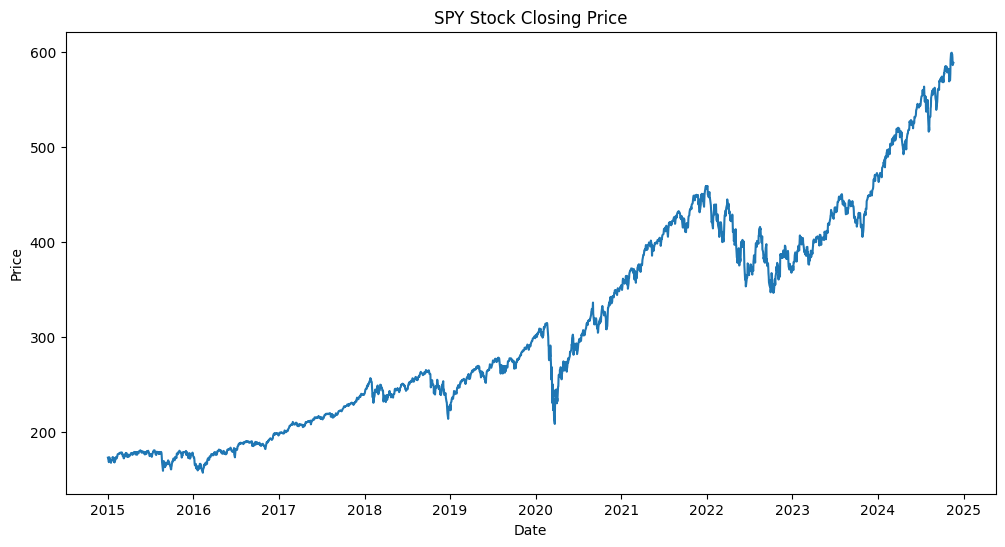

In [7]:
# Stock Closing Price
df_SPY['Close'].plot(figsize=(12, 6), title="SPY Stock Closing Price", xlabel='Date', ylabel='Price')
plt.show()

seasonal decomposition

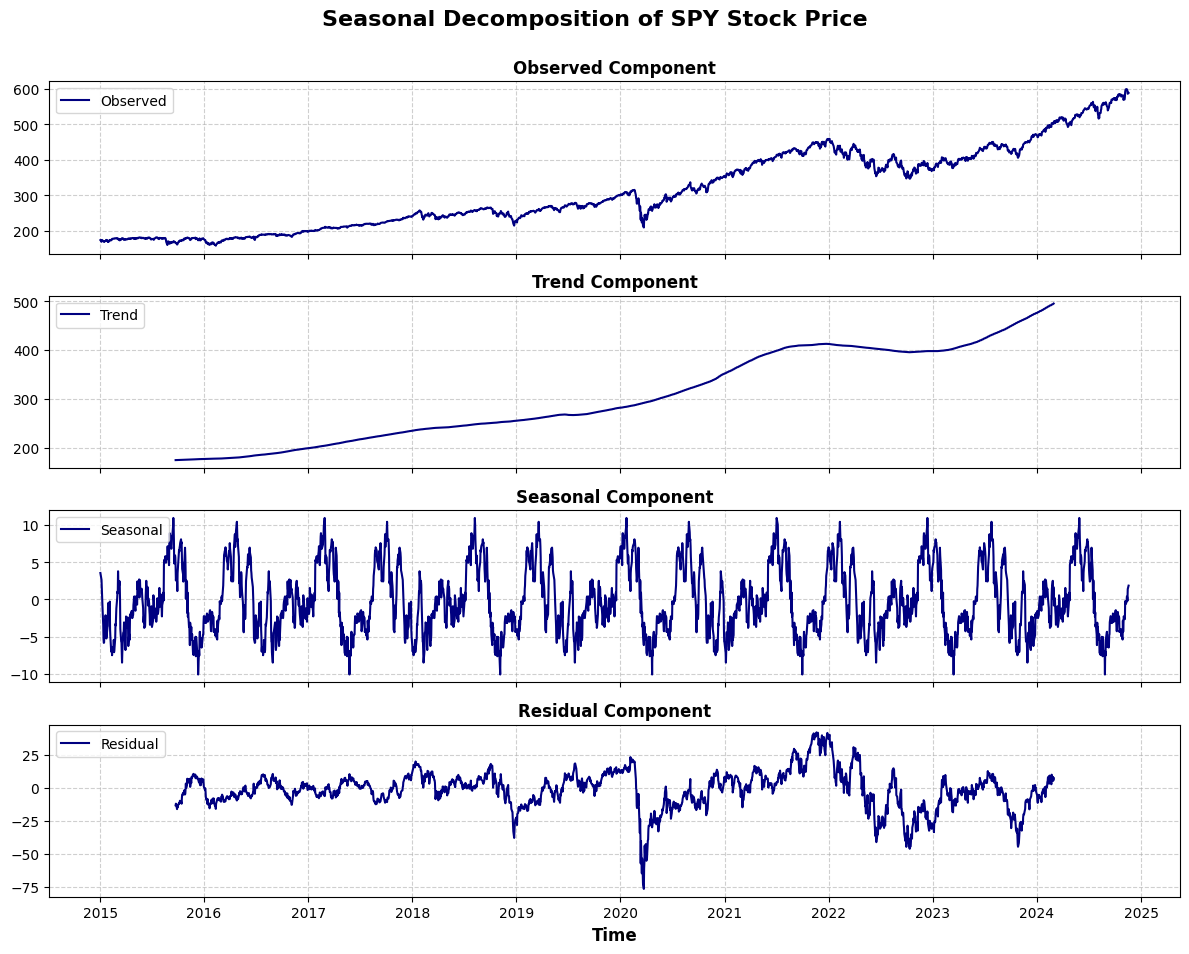

In [8]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(df_SPY['Close'], model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Plot each component separately
components = ['Observed', 'Trend', 'Seasonal', 'Residual']
plots = [decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid]

for ax, component, data in zip(axes, components, plots):
    ax.plot(data, label=component, color='navy', linewidth=1.5)
    ax.set_title(f"{component} Component", fontsize=12, fontweight='bold')
    ax.grid(visible=True, linestyle='--', alpha=0.6)
    ax.legend(loc="upper left")

plt.xlabel("Time", fontsize=12, fontweight='bold')
fig.suptitle("Seasonal Decomposition of SPY Stock Price", fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

ADF test for stationarity 

In [9]:
# Perform ADF test for stationarity 
adf_test(df_SPY['Close'], 'SPY')

ADF Test for SPY:
ADF Statistic: 1.099892608187544
p-value: 0.9952157059151187



ACF  and PACF for SPY Close price

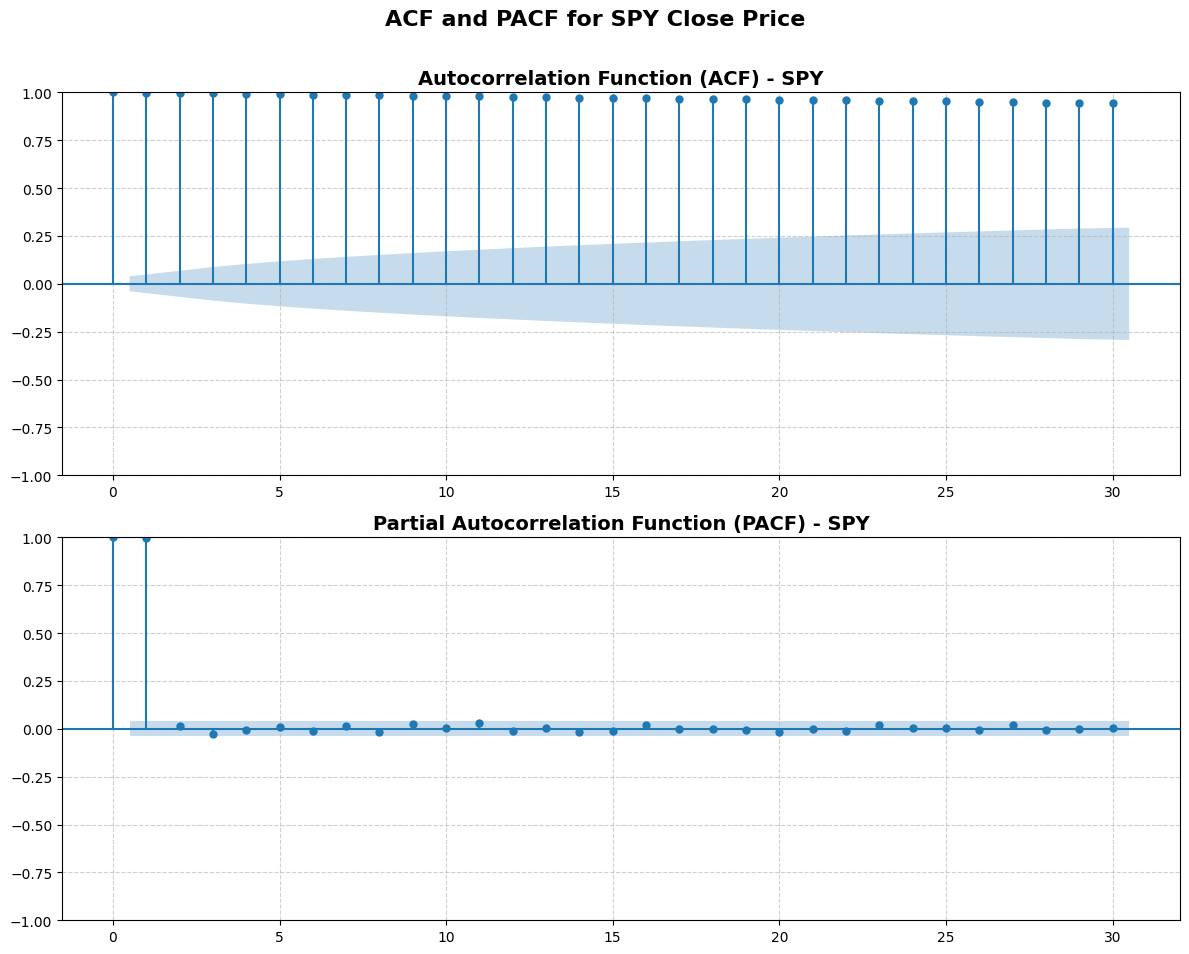

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Plot ACF for SPY Close price
plot_acf(df_SPY['Close'], ax=ax[0], lags=30)
ax[0].set_title("Autocorrelation Function (ACF) - SPY", fontsize=14, fontweight='bold')
ax[0].grid(visible=True, linestyle='--', alpha=0.6)

# Plot PACF for SPY Close price
plot_pacf(df_SPY['Close'], ax=ax[1], lags=30, method='ywm')
ax[1].set_title("Partial Autocorrelation Function (PACF) - SPY", fontsize=14, fontweight='bold')
ax[1].grid(visible=True, linestyle='--', alpha=0.6)

# Add a main title for the figure
fig.suptitle("ACF and PACF for SPY Close Price", fontsize=16, fontweight='bold', y=0.95)

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


In [11]:
# Check for missing values and fill them for SPY data
print("Missing values in SPY:")
print(df_SPY.isnull().sum())

# Fill missing values (if any)
df_SPY.fillna(method='ffill', inplace=True)
df_SPY.fillna(method='bfill', inplace=True)  # Optionally fill backward if leading NaNs exist

# Extract 'Close' prices for SPY after filling missing values
spy_close = df_SPY['Close']

#  Scale or normalize SPY ' Close' prices
# Example: min-max scaling
spy_close_scaled = (spy_close - spy_close.min()) / (spy_close.max() - spy_close.min())

print("SPY data preparation complete.")


Missing values in SPY:
Open             0
High             0
Low              0
Close            0
Volume           0
Dividends        0
Stock Splits     0
Capital Gains    0
Daily_Return     0
MA20             0
MA50             0
MA200            0
Volatility       0
dtype: int64
SPY data preparation complete.


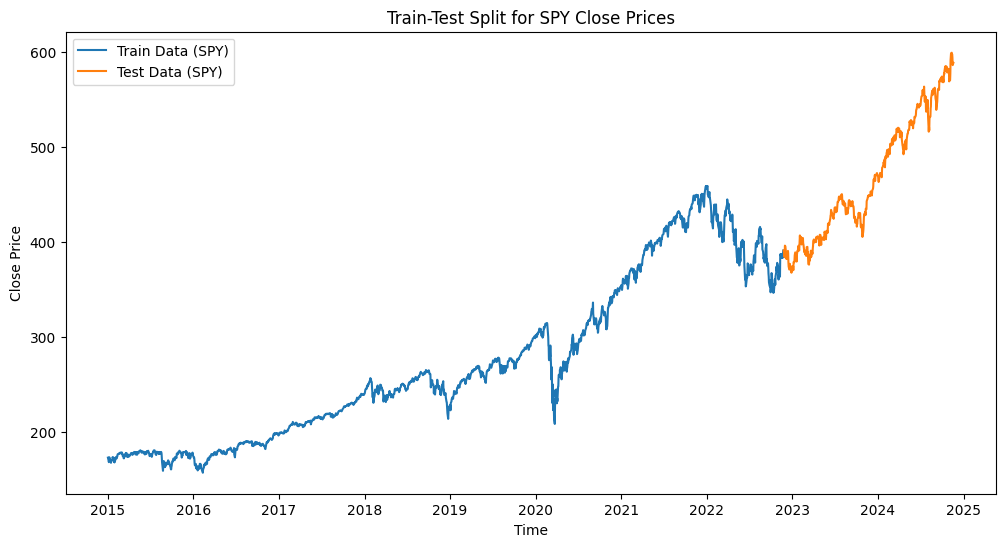

In [12]:
# Define the split ratio
split_ratio = 0.8
train_size = int(len(spy_close) * split_ratio)

# Split the data for SPY
spy_train, spy_test = spy_close[:train_size], spy_close[train_size:]

# Plot Train-Test Split for SPY
plt.figure(figsize=(12, 6))
plt.plot(spy_train, label='Train Data (SPY)')
plt.plot(spy_test, label='Test Data (SPY)')
plt.legend()
plt.title("Train-Test Split for SPY Close Prices")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()


### ARIMA MODEL 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10427.015, Time=1.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10517.752, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10500.400, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10502.157, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10517.808, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10499.857, Time=0.51 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10500.182, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=10481.260, Time=1.83 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=10489.377, Time=3.66 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10499.474, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=10500.371, Time=1.56 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10501.265, Time=1.46 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.49 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=10427.375, Time=0.94 sec

Best model:  ARIMA(2,1,2

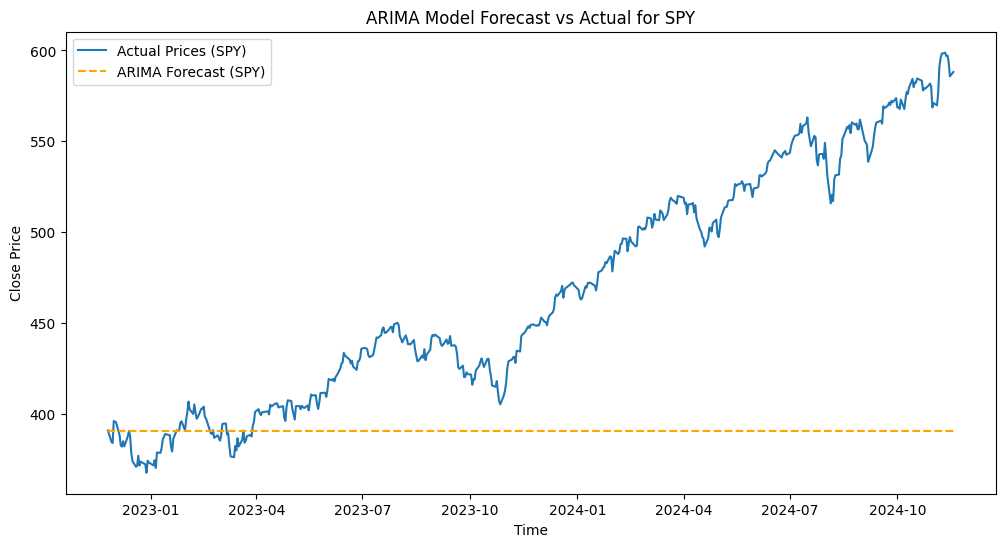

In [13]:
# Apply ARIMA for SPY
arima_forecast, spy_test, model_arima_fit = apply_arima(spy_train, spy_test)

# Plot actual vs ARIMA forecast for SPY
plt.figure(figsize=(12, 6))
plt.plot(spy_test.index, spy_test.values, label='Actual Prices (SPY)')
plt.plot(spy_test.index, arima_forecast, label='ARIMA Forecast (SPY)', linestyle='--', color='orange')

# Add title and legend
plt.title("ARIMA Model Forecast vs Actual for SPY")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()

Residual Analysis Plot
    residuals (difference between actual and forecasted values) to check for pattern.

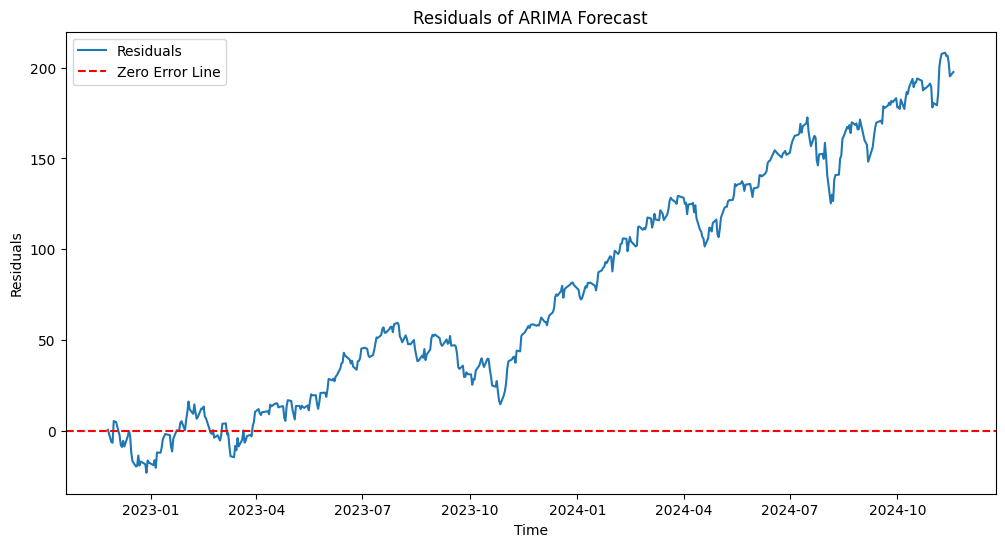

In [14]:
residuals = spy_test.values - arima_forecast
plt.figure(figsize=(12, 6))
plt.plot(spy_test.index, residuals, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error Line')
plt.title("Residuals of ARIMA Forecast")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.legend()
plt.show()


ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) Plots to understand whether residuals are white noise and whether any autocorrelation remains.

<Figure size 1200x600 with 0 Axes>

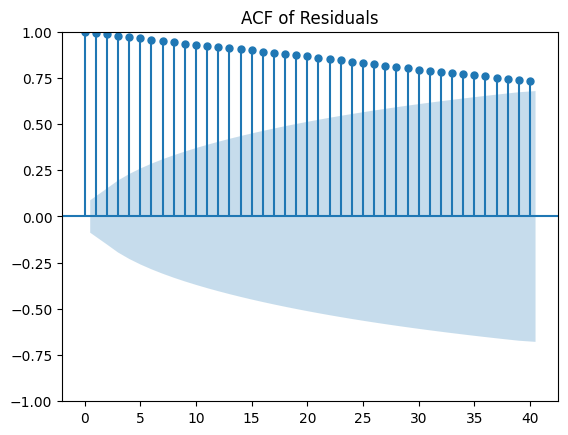

<Figure size 1200x600 with 0 Axes>

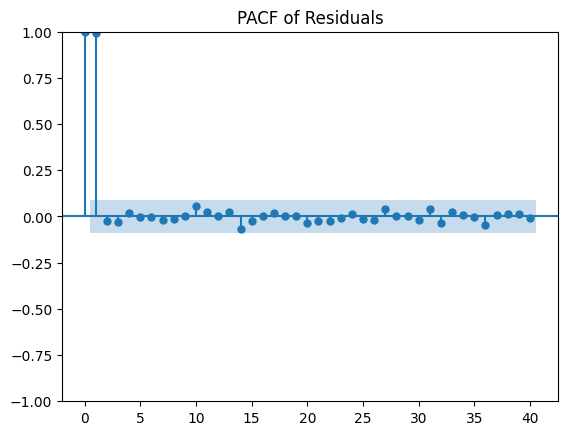

In [15]:
# ACF and PACF of residuals
plt.figure(figsize=(12, 6))
plot_acf(residuals, lags=40, title='ACF of Residuals')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(residuals, lags=40, title='PACF of Residuals')
plt.show()

In-sample Fit

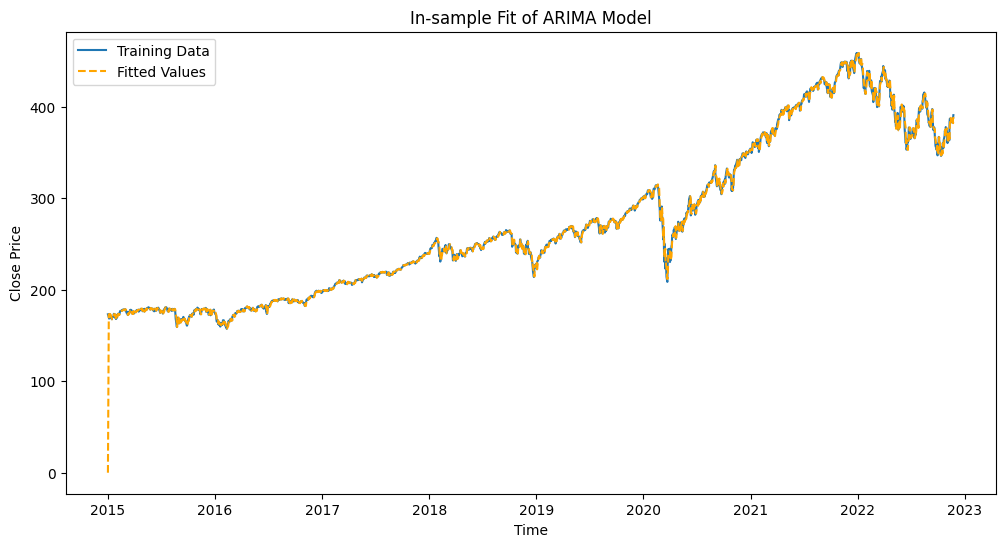

In [16]:
fitted_values = model_arima_fit.fittedvalues
plt.figure(figsize=(12, 6))
plt.plot(spy_train.index, spy_train.values, label='Training Data')
plt.plot(spy_train.index, fitted_values, label='Fitted Values', linestyle='--', color='orange')
plt.title("In-sample Fit of ARIMA Model")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()

Forecast with Prediction Intervals 

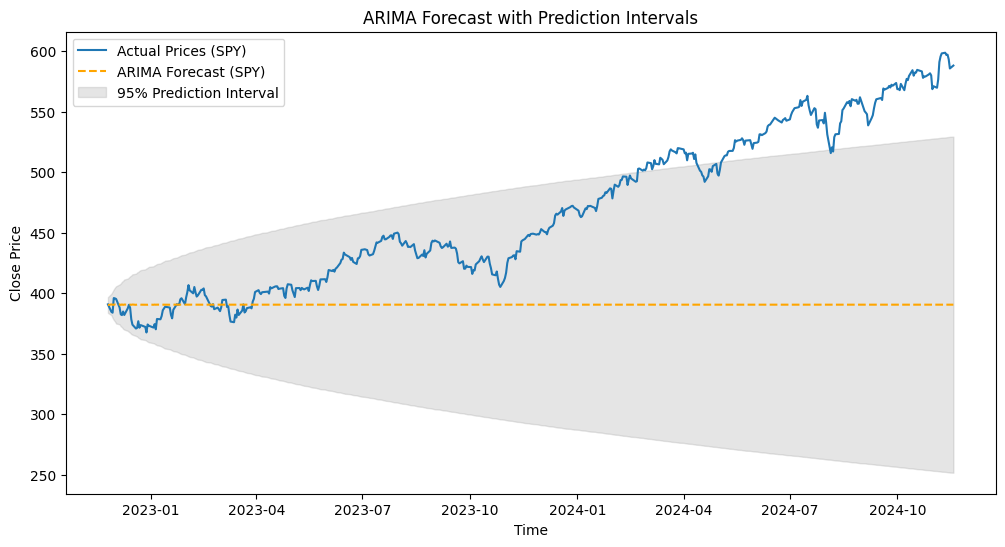

In [17]:
# Get forecast with confidence intervals
forecast_object = model_arima_fit.get_forecast(steps=len(spy_test))
forecast = forecast_object.predicted_mean
conf_int = forecast_object.conf_int(alpha=0.05)  # 95% prediction interval

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(spy_test.index, spy_test.values, label='Actual Prices (SPY)')
plt.plot(spy_test.index, forecast, label='ARIMA Forecast (SPY)', linestyle='--', color='orange')
plt.fill_between(spy_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label='95% Prediction Interval')
plt.title("ARIMA Forecast with Prediction Intervals")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()

Distribution of Residuals 

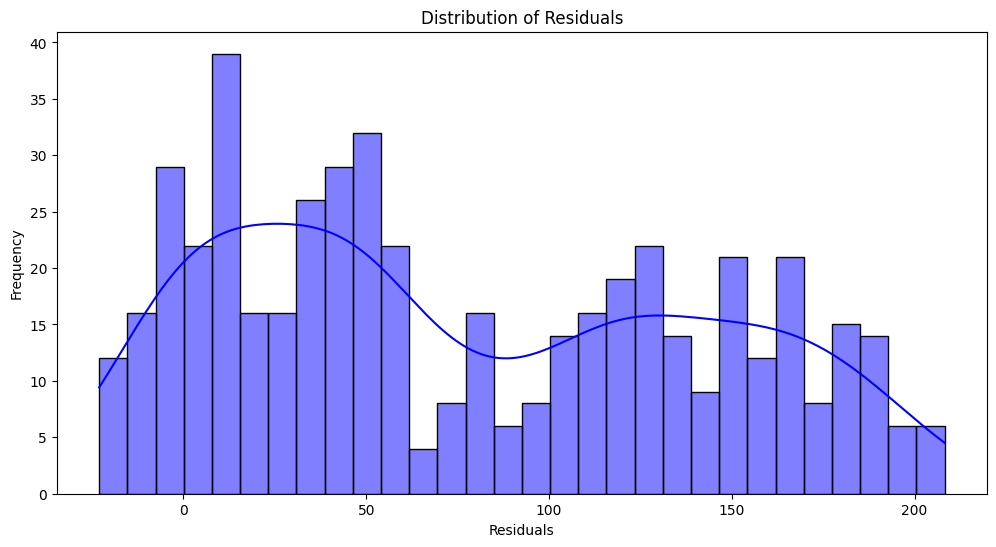

In [18]:
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

ARIMA model’s diagnostic plots to check for heteroscedasticity, normality, and autocorrelation.

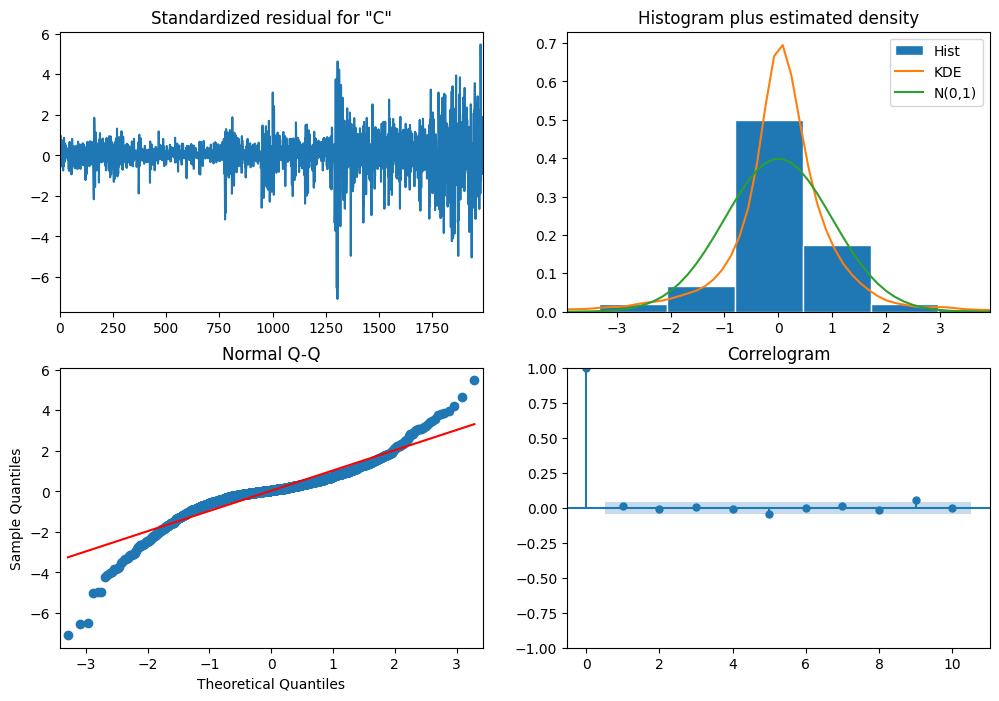

In [19]:
model_arima_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

Rolling Mean and Standard Deviation

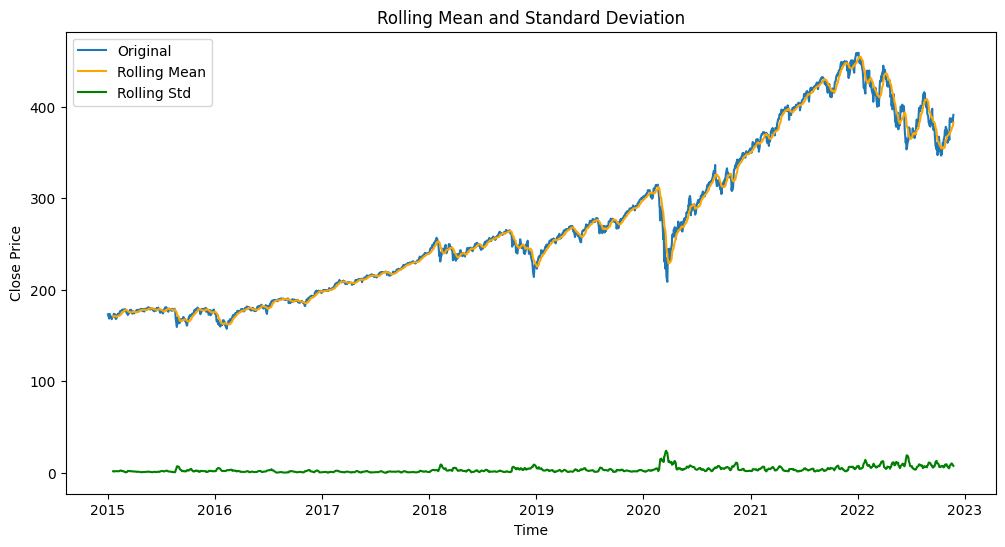

In [20]:
rolling_mean = spy_train.rolling(window=12).mean()
rolling_std = spy_train.rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(spy_train, label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='orange')
plt.plot(rolling_std, label='Rolling Std', color='green')
plt.title("Rolling Mean and Standard Deviation")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()

### SARIMA MODEL 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=10517.752, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=10502.309, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=10504.066, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=10517.808, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=10500.400, Time=0.09 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=10502.305, Time=0.38 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=10504.267, Time=1.04 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=10498.182, Time=0.15 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=10500.105, Time=0.53 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=10500.103, Time=0.47 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=10502.097, Time=0.59 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=10500.182, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=10499.474, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=10498.463, Time=0.10 sec

Best

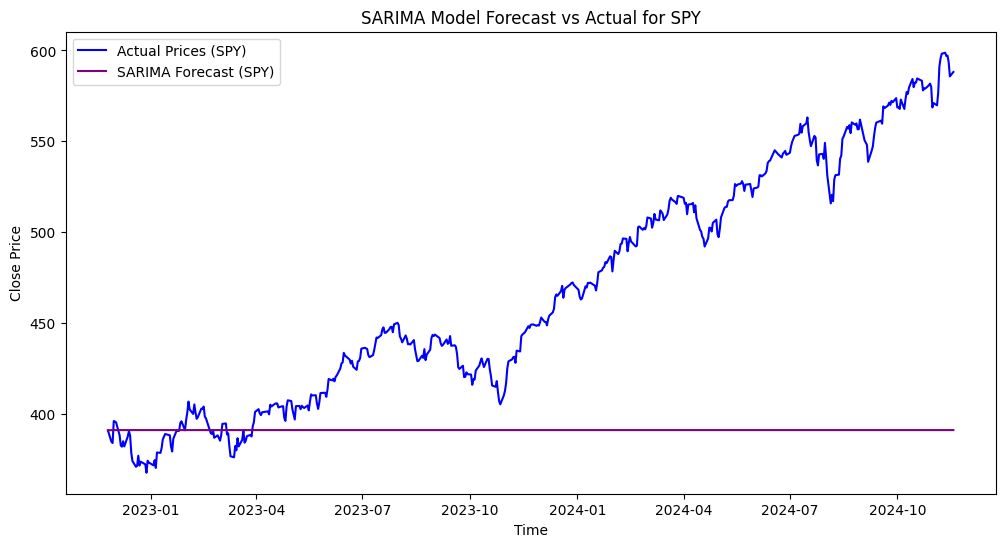

In [21]:
# SARIMA modeling for SPY
# Automatically find the optimal SARIMA parameters with restricted search space
sarima_model_spy = pm.auto_arima(
    spy_train,
    seasonal=True,
    m=12,
    start_p=0, max_p=2,    # Restrict p parameters
    start_q=0, max_q=2,    # Restrict q parameters
    start_P=0, max_P=1,    # Restrict seasonal P parameters
    start_Q=0, max_Q=1,    # Restrict seasonal Q parameters
    max_d=1,               # Restrict differencing
    max_D=1,               # Restrict seasonal differencing
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,         # Use stepwise search instead of grid search
    n_fits=10             # Limit number of models to evaluate
)

print(f"Optimal SARIMA parameters for SPY: {sarima_model_spy.order}x{sarima_model_spy.seasonal_order}")

# Fit the SARIMA model with optimized settings
model_sarima_spy = SARIMAX(
    spy_train,
    order=sarima_model_spy.order,
    seasonal_order=sarima_model_spy.seasonal_order,
    enforce_stationarity=False,    # Speed up fitting
    enforce_invertibility=False    # Speed up fitting
)

# Fit with optimized solver settings
model_sarima_fit_spy = model_sarima_spy.fit(
    disp=False,
    method='lbfgs',    # Faster optimization algorithm
    maxiter=50         # Limit maximum iterations
)

# Forecast for the test period
sarima_forecast_spy = model_sarima_fit_spy.forecast(steps=len(spy_test))

# Plot actual vs SARIMA forecast for spy
plt.figure(figsize=(12, 6))
plt.plot(spy_test, label='Actual Prices (SPY)', color='blue')
plt.plot(spy_test.index, sarima_forecast_spy, label='SARIMA Forecast (SPY)', color='purple')
plt.legend()
plt.title("SARIMA Model Forecast vs Actual for SPY")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()

 Residuals

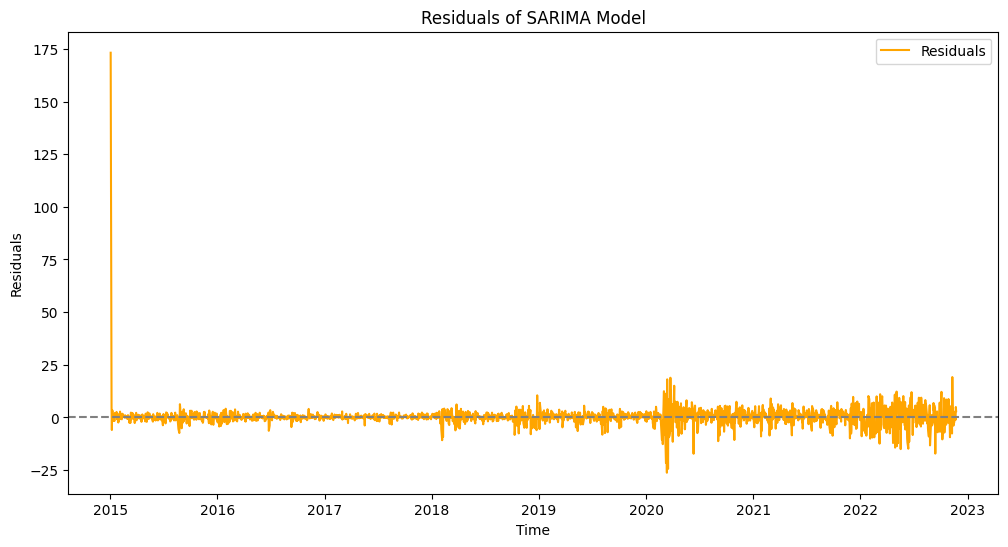

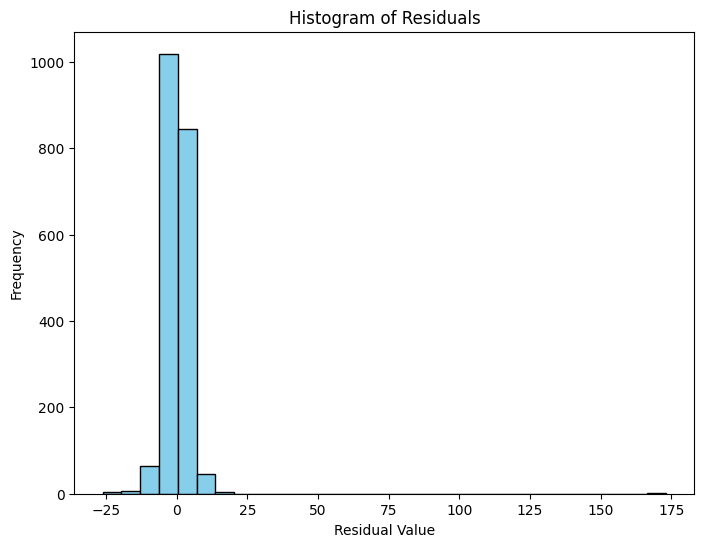

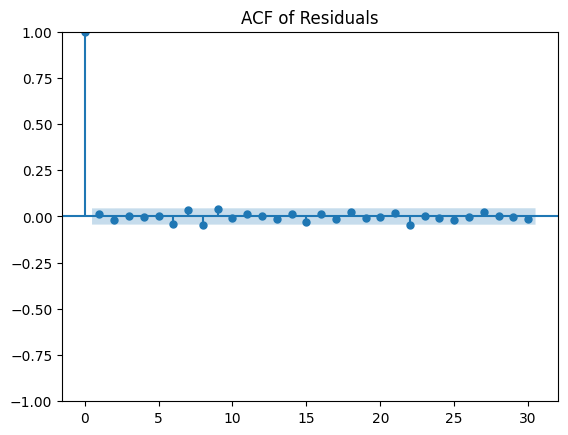

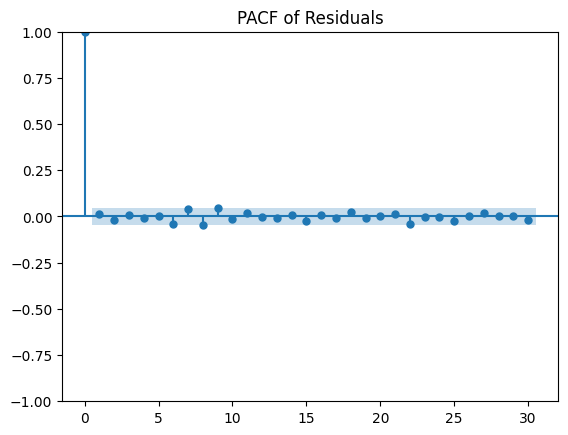

In [22]:
# Residuals
residuals = model_sarima_fit_spy.resid

# Plot residuals time series
plt.figure(figsize=(12, 6))
plt.plot(residuals, label="Residuals", color="orange")
plt.axhline(0, linestyle="--", color="gray")
plt.title("Residuals of SARIMA Model")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.legend()
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color="skyblue", edgecolor="black")
plt.title("Histogram of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.show()


# ACF and PACF of residuals
plot_acf(residuals, lags=30)
plt.title("ACF of Residuals")
plt.show()

plot_pacf(residuals, lags=30)
plt.title("PACF of Residuals")
plt.show()


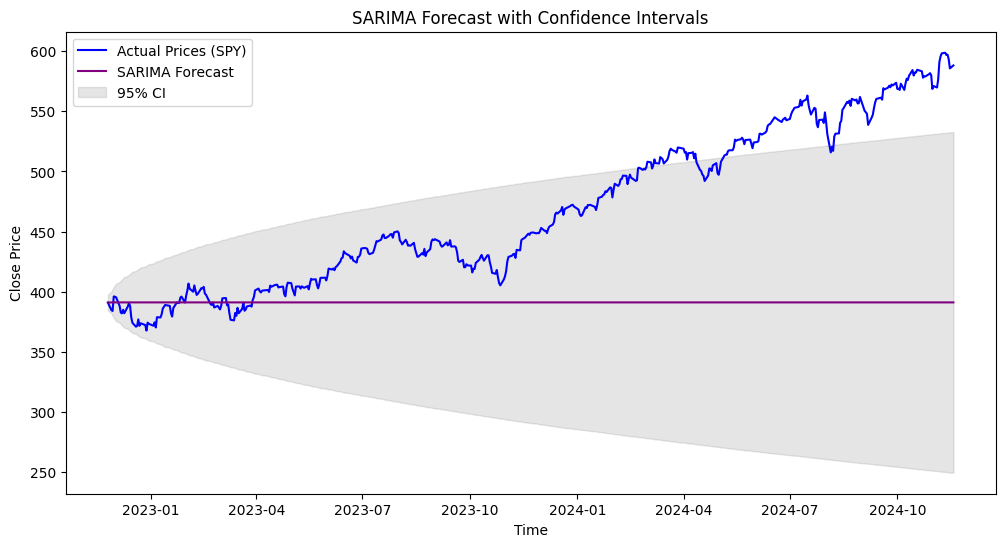

In [23]:
# Get forecast with confidence intervals
forecast_object = model_sarima_fit_spy.get_forecast(steps=len(spy_test))
forecast = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()

# Plot forecast with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(spy_test, label="Actual Prices (SPY)", color="blue")
plt.plot(spy_test.index, forecast, label="SARIMA Forecast", color="purple")
plt.fill_between(spy_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color="gray", alpha=0.2, label="95% CI")
plt.legend()
plt.title("SARIMA Forecast with Confidence Intervals")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()

Sarima Model Diagnostics 

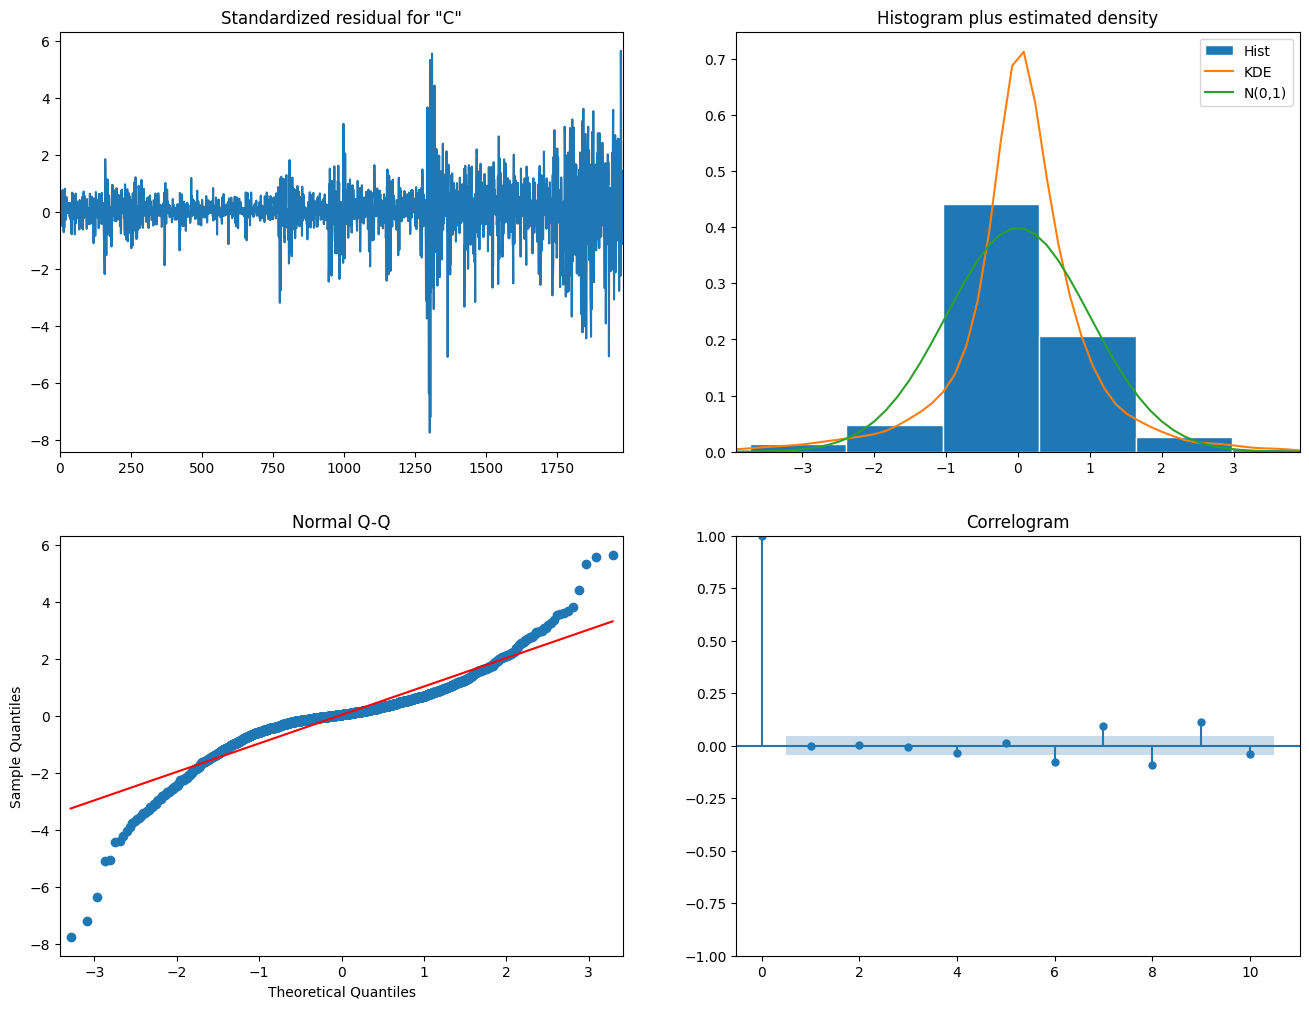

In [24]:
# Model diagnostics
model_sarima_fit_spy.plot_diagnostics(figsize=(16, 12))
plt.show()

In [25]:
mae = mean_absolute_error(spy_test, sarima_forecast_spy)
rmse = np.sqrt(mean_squared_error(spy_test, sarima_forecast_spy))
mape = np.mean(np.abs((spy_test - sarima_forecast_spy) / spy_test)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 78.87370542156214
Root Mean Squared Error (RMSE): 100.24267764644749
Mean Absolute Percentage Error (MAPE): nan%


In [26]:
# Generate forecast and confidence intervals
forecast_object = model_sarima_fit_spy.get_forecast(steps=len(spy_test))
conf_intervals = forecast_object.conf_int()

# Rename columns for clarity
conf_intervals.columns = ['Lower Close', 'Upper Close']

# Display the confidence intervals as a table
print(conf_intervals)


      Lower Close  Upper Close
1989   384.273437   397.553881
1990   382.062895   399.992832
1991   380.006260   402.029786
1992   378.322490   403.726183
1993   376.820729   405.225840
...           ...          ...
2482   249.881283   532.165949
2483   249.738499   532.308732
2484   249.595859   532.451372
2485   249.453363   532.593868
2486   249.311011   532.736221

[498 rows x 2 columns]


### LSTM MODEL 

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.1193e-04
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.9415e-04
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.8475e-04
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9809e-04
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7118e-04
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8139e-04
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.7568e-04
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5569e-04
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6893e-04
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.4751e-04
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7597e-04
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7014e-04
Epoch 13/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.4002e-04
Epoch 14/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8072e-04
Epoch 15/50
61/

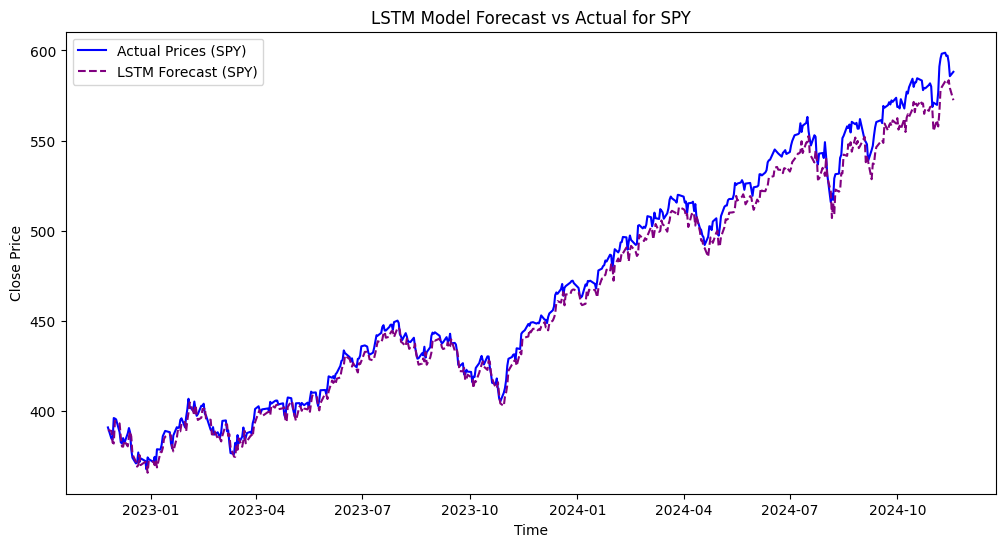

In [27]:
# Apply LSTM to SPY data
scaler, X_train, y_train, X_test, spy_test = prepare_lstm_data(spy_train, spy_test)

# Build, train, and predict with the LSTM model
model_lstm = build_lstm_model(X_train)
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
lstm_forecast = train_and_predict_lstm(model_lstm, X_train, y_train, X_test)

# Inverse transform predictions to original scale
lstm_forecast = scaler.inverse_transform(lstm_forecast)

# Plot actual vs LSTM forecast for SPY
plt.figure(figsize=(12, 6))
plt.plot(spy_test.index, spy_test.values, label='Actual Prices (SPY)', color='blue')
plt.plot(spy_test.index, lstm_forecast, label='LSTM Forecast (SPY)', linestyle='--', color='purple')
plt.title("LSTM Model Forecast vs Actual for SPY")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()

LSTM Training Loss 

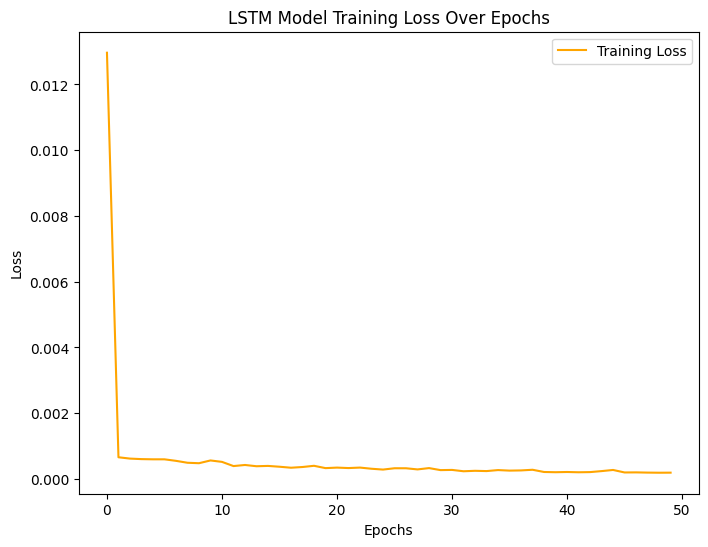

In [28]:
# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.title("LSTM Model Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

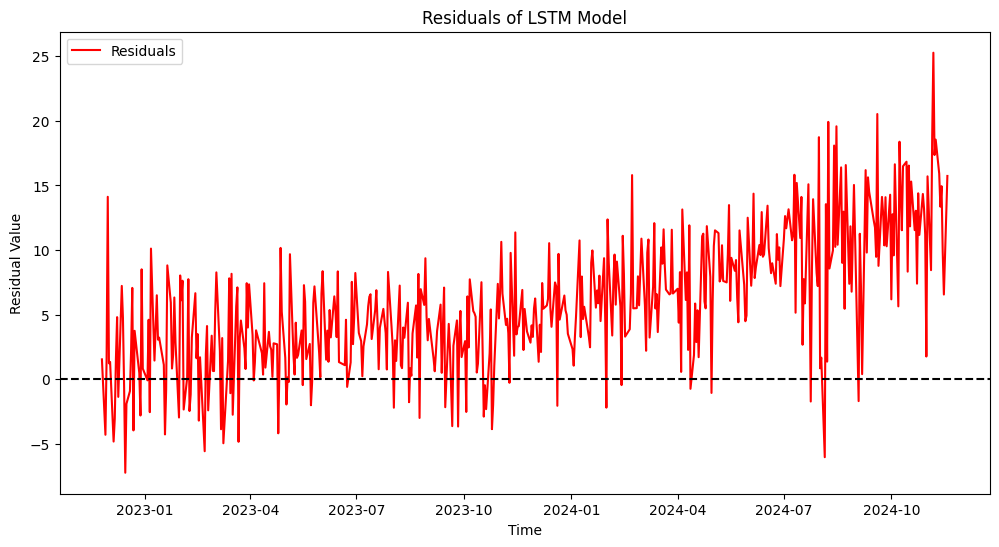

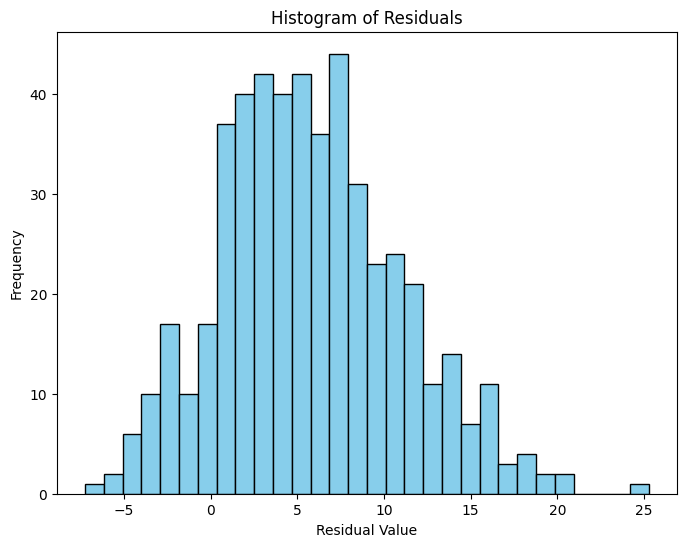

In [29]:
# Residuals
residuals = spy_test.values - lstm_forecast.flatten()

# Plot residuals time series
plt.figure(figsize=(12, 6))
plt.plot(spy_test.index, residuals, label="Residuals", color="red")
plt.axhline(0, linestyle="--", color="black")
plt.title("Residuals of LSTM Model")
plt.xlabel("Time")
plt.ylabel("Residual Value")
plt.legend()
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color="skyblue", edgecolor="black")
plt.title("Histogram of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.show()


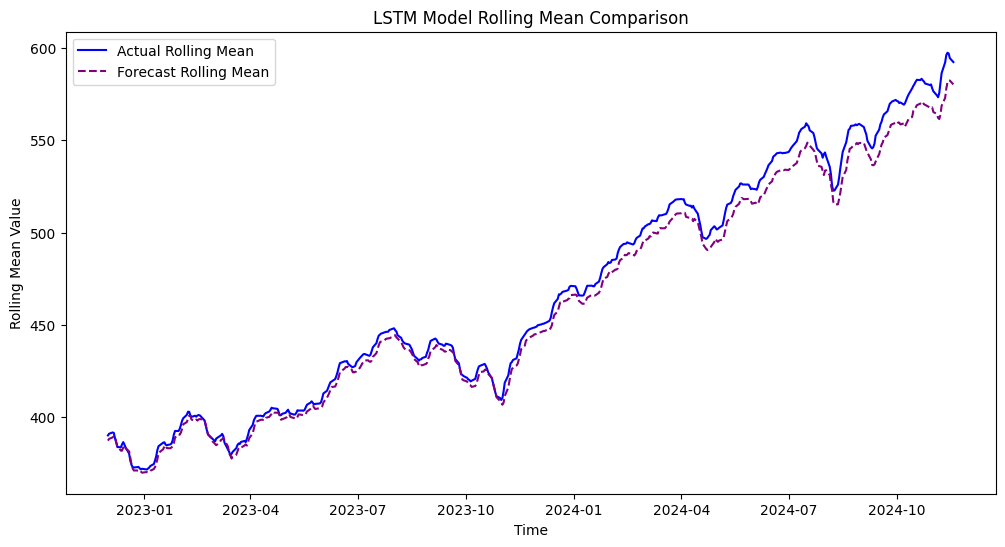

In [30]:
# Rolling means
actual_rolling = spy_test.rolling(window=5).mean()
forecast_rolling = pd.Series(lstm_forecast.flatten(), index=spy_test.index).rolling(window=5).mean()

plt.figure(figsize=(12, 6))
plt.plot(spy_test.index, actual_rolling, label="Actual Rolling Mean", color="blue")
plt.plot(spy_test.index, forecast_rolling, label="Forecast Rolling Mean", linestyle="--", color="purple")
plt.title("LSTM Model Rolling Mean Comparison")
plt.xlabel("Time")
plt.ylabel("Rolling Mean Value")
plt.legend()
plt.show()

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


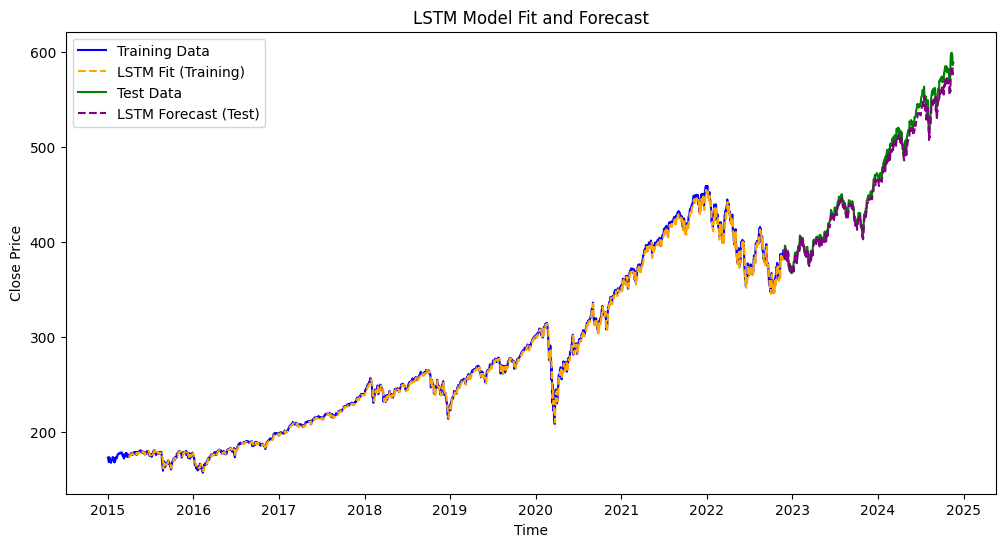

In [31]:
# Get training predictions
train_predictions = model_lstm.predict(X_train)
train_predictions = scaler.inverse_transform(train_predictions)

plt.figure(figsize=(12, 6))
plt.plot(spy_train.index, spy_train.values, label="Training Data", color="blue")
plt.plot(spy_train.index[60:], train_predictions.flatten(), label="LSTM Fit (Training)", linestyle="--", color="orange")
plt.plot(spy_test.index, spy_test.values, label="Test Data", color="green")
plt.plot(spy_test.index, lstm_forecast.flatten(), label="LSTM Forecast (Test)", linestyle="--", color="purple")
plt.title("LSTM Model Fit and Forecast")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()


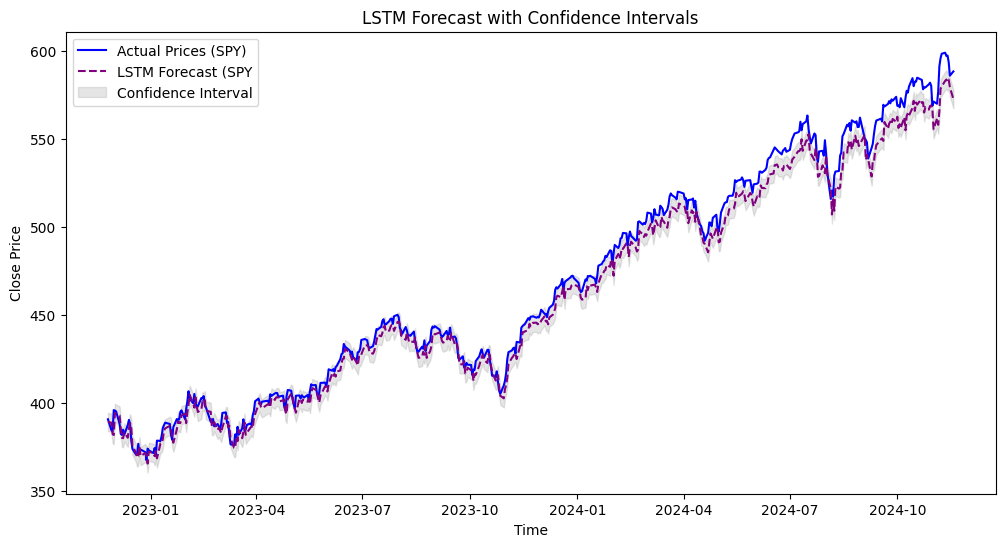

In [32]:
# Compute confidence intervals (e.g., ± standard deviation of residuals)
forecast_std = np.std(residuals)
lower_bound = lstm_forecast.flatten() - forecast_std
upper_bound = lstm_forecast.flatten() + forecast_std

plt.figure(figsize=(12, 6))
plt.plot(spy_test.index, spy_test.values, label="Actual Prices (SPY)", color="blue")
plt.plot(spy_test.index, lstm_forecast.flatten(), label="LSTM Forecast (SPY", linestyle="--", color="purple")
plt.fill_between(spy_test.index, lower_bound, upper_bound, color="gray", alpha=0.2, label="Confidence Interval")
plt.title("LSTM Forecast with Confidence Intervals")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()


In [33]:
mae = mean_absolute_error(spy_test, lstm_forecast)
rmse = np.sqrt(mean_squared_error(spy_test, lstm_forecast))
mape = np.mean(np.abs((spy_test.values - lstm_forecast.flatten()) / spy_test.values)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 6.3187554907128565
Root Mean Squared Error (RMSE): 7.756598469069976
Mean Absolute Percentage Error (MAPE): 1.29%


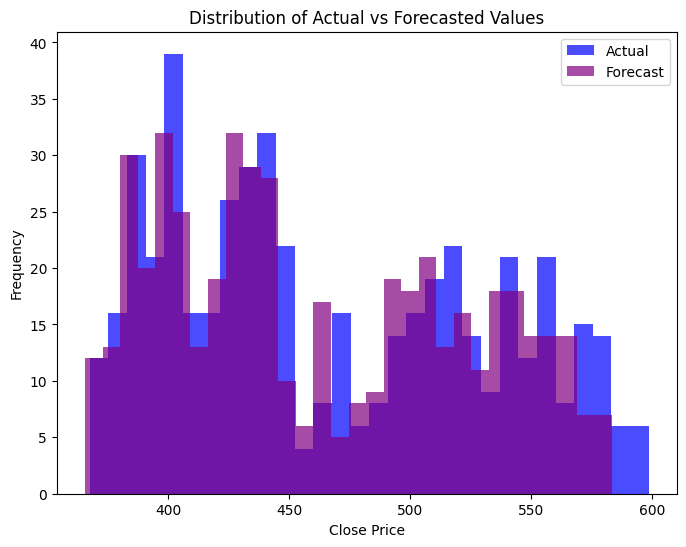

In [34]:
plt.figure(figsize=(8, 6))
plt.hist(spy_test.values, bins=30, alpha=0.7, label="Actual", color="blue")
plt.hist(lstm_forecast.flatten(), bins=30, alpha=0.7, label="Forecast", color="purple")
plt.title("Distribution of Actual vs Forecasted Values")
plt.xlabel("Close Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Model Comparision 

In [36]:
# Evaluate models
arima_mae, arima_rmse, arima_mape = calculate_metrics(spy_test, arima_forecast)
sarima_mae, sarima_rmse, sarima_mape = calculate_metrics(spy_test, sarima_forecast_spy)
lstm_mae, lstm_rmse, lstm_mape = calculate_metrics(spy_test, lstm_forecast)

# Create a DataFrame for the metrics
metrics_data = {
    "Model": ["ARIMA", "SARIMA", "LSTM"],
    "MAE": [arima_mae, sarima_mae, lstm_mae],
    "RMSE": [arima_rmse, sarima_rmse, lstm_rmse],
    "MAPE": [arima_mape, sarima_mape, lstm_mape],
}

metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)

    Model        MAE        RMSE      MAPE
0   ARIMA  79.241219  100.611396  0.154710
1  SARIMA  78.873705  100.242678  0.153959
2    LSTM   6.318755    7.756598  0.012888
